# Social Media Virality using Networks

This experiment investigates the dynamics of content virality on social media platforms by simulating the spread of posts within a modeled network. I built this notebook because I wanted to explore how various factors such as sharing probability, user activity levels, and content visibility duration impact the rate and extent of viral spread. By manipulating these parameters in a controlled simulation environment, it is possible to observe and isolate specific influences and gain insights into the factors that might enhance or inhibit the spread of online content.

### Import libraries

In [1]:
# import
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from IPython.display import clear_output

### Initializing the model

This section of the code sets up the initial conditions for the simulation. It creates a network of users (nodes) connected by their relationships (edges). Each user's initial state (online or offline, has seen or shared the post) is defined here. This setup provides the baseline from which the virality of the post can be observed and measured.

The model utilizes a network-based approach to represent individual users as nodes and their connections as edges, employing the Watts-Strogatz small-world network to approximate real-world social network topologies. Each node, representing a user, can be online or offline at any given time, dictated by a predefined probability of flipping online status (initially a 20% flip chance), and a starting population of 80% of users online. Besides their online status, users must always be in one of three states:
- **Not seen:** where the user is unaware of the post
- **Seen:** where the user has seen the post from a connected user (i.e., a friend on social media)
- **Shared:** indicating that the user has both seen and shared the post to their own feed

In [2]:
def initialize(online_probability=0.8):

  num_nodes = 50
  global peak_virality

  peak_virality = 1

  network = nx.watts_strogatz_graph(num_nodes, k=5, p=0.2)

  # initialize all nodes to have not seen or shared the post
  for node in network.nodes():
    network.nodes[node]['seen_post'] = 0
    network.nodes[node]['shared_post'] = 0
    network.nodes[node]['time_shared'] = 0

    # initialize about 80% of the network to be online
    if random.random() < online_probability:
      network.nodes[node]['online'] = 1
    else:
      network.nodes[node]['online'] = 0

  # select initial node to share post
  initial_sharer = random.choice(list(network.nodes()))
  network.nodes[initial_sharer]['shared_post'] = 1
  network.nodes[initial_sharer]['seen_post'] = 1
  network.nodes[initial_sharer]['online'] = 1


  network.pos = nx.kamada_kawai_layout(network)
  return network

### Observing the initial network

In this part of the code, we visualize the network's initial state. It colors nodes based on their initial status. Initially, the post spreads from a single initial sharer (the red node in the visual below). Here's a brief guide to the colors of the nodes:

- **Not seen:** represented by a gray node
- **Seen:** represented by a yellow node
- **Shared:** represented by a red node

Solid nodes represent online users at a given timestep, and translucent nodes represent offline users at a given timestep.

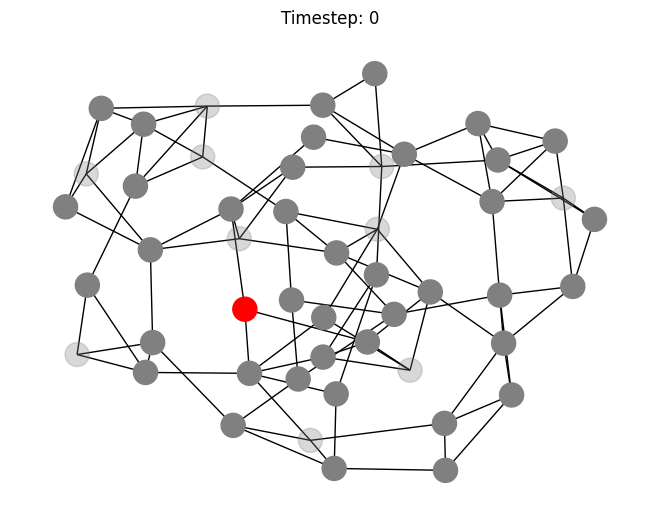

In [3]:
# Observe the initial network
def observe(network, timestep):
  node_colors = []
  for node in network.nodes():
    if network.nodes[node]['shared_post'] == 1:
      color = 'red'
    elif network.nodes[node]['seen_post'] == 1:
      color = 'yellow'
    else:
      color = 'gray'

    alpha = 1.0 if network.nodes[node]['online'] == 1 else 0.3
    rgba_color = matplotlib.colors.to_rgba(color, alpha)
    node_colors.append(rgba_color)

  #plt.figure(figsize=(12,8))
  nx.draw(network, pos=network.pos, node_color=node_colors, with_labels=False)
  plt.title(f"Timestep: {timestep}")
  plt.show()


network = initialize()
observe(network, 0)

### Updating the model

This section contains the logic for the simulation's progression. It updates the state of each user in the network based on predefined probabilities, including whether they will share the post if they have seen it, and whether they will go offline or come online (as defined by the flip probability). This iterative updating mimics the dynamic nature of social media interactions and the spread of content through a network. The output of the function is the peak virality of the post, which represents the extent of the broadest reach that the post has on the network throughout the simulation.

In [4]:
def update_network(network, sharing_prob=0.8, flip_prob=0.2, shared_duration=5):
    global peak_virality

    # For each node that is sharing, mark all online neighbors as having seen the post
    for node in network.nodes():
        if network.nodes[node]['shared_post'] == 1:
            for neighbor in network.neighbors(node):
                if network.nodes[neighbor]['online'] == 1:
                    network.nodes[neighbor]['seen_post'] = 1

    # Flip online status with a certain probability
    for node in network.nodes():
        if random.random() < flip_prob:
            network.nodes[node]['online'] = 1 - network.nodes[node]['online']

        # If a node has shared the post, increase the time shared
        if network.nodes[node]['shared_post'] == 1:
            network.nodes[node]['time_shared'] += 1

            # If shared duration is reached, remove the post and reset time shared
            if network.nodes[node]['time_shared'] >= shared_duration:
                network.nodes[node]['shared_post'] = 0
                network.nodes[node]['time_shared'] = 0

    # Spread the post
    for node in network.nodes():
        # Check if node is online and has seen but not shared the post
        if network.nodes[node]['online'] == 1 and network.nodes[node]['seen_post'] == 1 and network.nodes[node]['shared_post'] == 0:
            # Node decides to share the post based on sharing probability
            if random.random() < sharing_prob:
                network.nodes[node]['shared_post'] = 1
                network.nodes[node]['time_shared'] = 1  # Reset time shared

                # Neighbors of the node now see the post
                for neighbor in network.neighbors(node):
                    if network.nodes[neighbor]['online'] == 1:
                        network.nodes[neighbor]['seen_post'] = 1


    # Count the current number of sharers
    current_sharers = sum(1 for node in network.nodes() if network.nodes[node]['shared_post'] == 1)

    # Update peak virality if the current number of sharers is greater than the peak
    if current_sharers > peak_virality:
        peak_virality = current_sharers

    return peak_virality



### Running the model

This section initializes the netork and calles `update_network` for each timestep, observing the network as it runs. It outputs the peak virality after the simulation has completed.

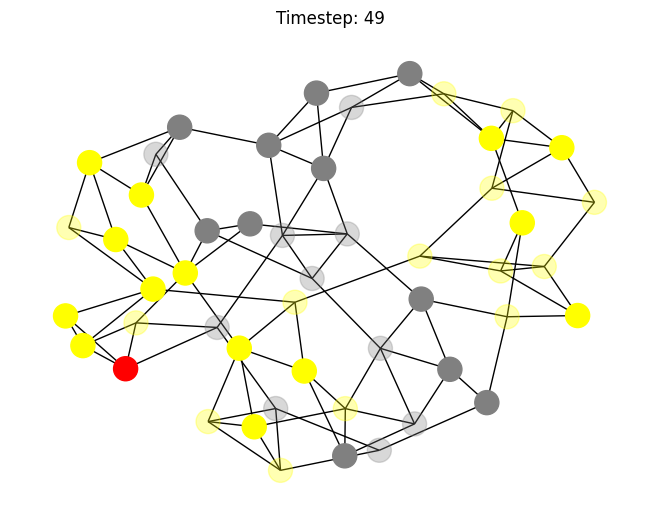

Peak virality: 6


In [5]:
def run_simulation(timesteps=50, sharing_prob=0.1, flip_prob=0.2):
    global peak_virality
    # Initialize the network
    network = initialize()

    # Run the simulation
    for t in range(timesteps):
        update_network(network, sharing_prob, flip_prob)
        clear_output(wait=True)
        observe(network, t)
        time.sleep(0.5)

    # Print the peak virality after the simulation
    print(f"Peak virality: {peak_virality}")


# Run the entire simulation
run_simulation()


# Parameter sweeps

This section sets up and runs multiple simulations with varying parameters to observe how changes in these parameters affect the outcome of the simulation. The x-axis contains a consistent sweep of sharing probability across all three sweeps in order to simulate the experiment across different levels of content popularity (i.e., content with a 0.1 sharing probability represents content that might not be particularly interesting, whereas a sharing probability of 0.5 indicates that a post is very engaging).

Each sweep systematically alters another parameter across the y-axis: the duration a post is shared, the users' initial online probability, and the online/offline flip probability. Each sweep records the peak virality reached in each scenario.


### Sharing probability vs. Shared duration




[[ 6.  7.  7. 10. 13. 11. 14. 18. 19.]
 [ 2.  6.  7. 10. 12. 15. 16. 17. 21.]
 [ 5.  8. 14.  9. 17. 19. 21. 20. 21.]
 [ 9. 13. 16. 17. 23. 25. 26. 27. 28.]
 [ 8. 17. 23. 21. 24. 31. 27. 31. 33.]
 [10. 19. 23. 25. 26. 29. 33. 32. 33.]
 [10. 14. 25. 30. 27. 31. 35. 31. 35.]
 [18. 23. 26. 28. 31. 30. 39. 37. 36.]
 [15. 18. 31. 29. 34. 34. 37. 39. 37.]
 [11. 24. 24. 33. 31. 38. 40. 41. 42.]]


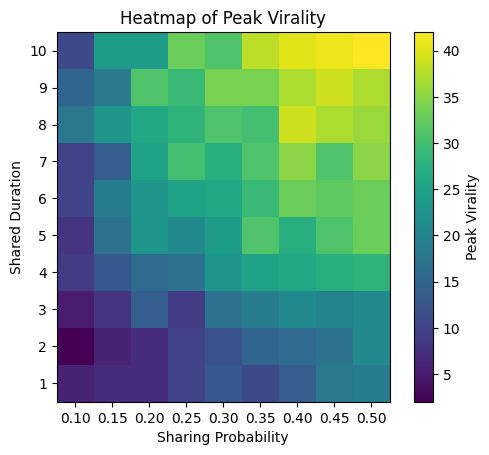

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Adjust run_simulation to accept sharing_prob and shared_duration, and to return peak_virality
def run_sweep(network, timesteps=50, sharing_prob=0.1, flip_prob=0.2, shared_duration=10):
    global peak_virality
    peak_virality = 0
    for t in range(timesteps):
        peak_virality = update_network(network, sharing_prob, flip_prob, shared_duration)
    return peak_virality

# Set up the parameter sweep range
sharing_probs = np.arange(0.1, 0.55, 0.05)  # Sharing probability from 0.1 to 0.5
shared_durations = np.arange(1, 11, 1)  # Shared duration from 1 to 10

# Initialize the results matrix
results = np.zeros((len(shared_durations), len(sharing_probs)))

# Run the parameter sweep
for i, shared_duration in enumerate(shared_durations):
    for j, sharing_prob in enumerate(sharing_probs):
        network = initialize()
        peak_virality = run_sweep(network, sharing_prob=sharing_prob, shared_duration=shared_duration)
        results[i, j] = peak_virality

print(results)

# Create a heatmap to visualize the peak virality
fig, ax = plt.subplots()

# Create the heatmap using the results matrix
cax = ax.imshow(results, cmap='viridis', origin='lower')

# Add a colorbar with a label
cbar = fig.colorbar(cax)
cbar.set_label('Peak Virality')

# Set the tick marks for the sharing probability on the x-axis
sharing_probs_labels = np.arange(0.1, 0.55, 0.05)
ax.set_xticks(np.arange(len(sharing_probs_labels)))
ax.set_xticklabels(['{:.2f}'.format(p) for p in sharing_probs_labels])

# Set the tick marks for the shared duration on the y-axis
shared_durations_labels = np.arange(1, 11, 1)
ax.set_yticks(np.arange(len(shared_durations_labels)))
ax.set_yticklabels(['{}'.format(d) for d in shared_durations_labels])

# Label the axes
ax.set_xlabel('Sharing Probability')
ax.set_ylabel('Shared Duration')

# Set the title of the heatmap
ax.set_title('Heatmap of Peak Virality')

# Display the plot
plt.show()


### Sharing probability vs. Online probability

[[13. 21. 20. 30. 35. 34. 35. 37. 36.]
 [10. 20. 25. 31. 33. 35. 37. 37. 41.]
 [17. 23. 24. 30. 31. 34. 34. 36. 39.]
 [20. 21. 26. 26. 31. 37. 39. 33. 36.]
 [13. 25. 31. 33. 32. 34. 34. 43. 39.]
 [13. 28. 21. 31. 32. 36. 35. 39. 38.]
 [11. 24. 16. 31. 33. 34. 38. 40. 42.]
 [ 6. 20. 27. 30. 30. 33. 36. 37. 39.]
 [17. 25. 21. 29. 34. 34. 36. 34. 36.]
 [24. 14. 33. 32. 35. 37. 36. 40. 41.]]


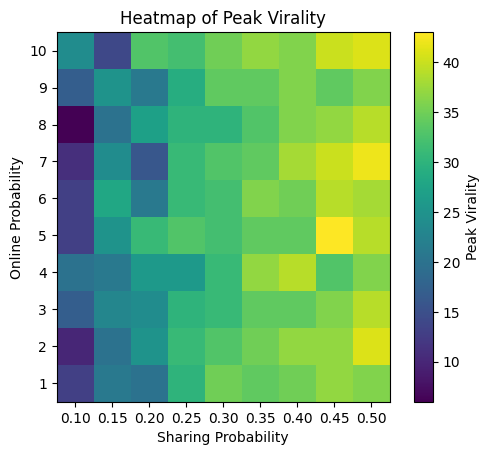

In [7]:

# Adjust run_simulation to accept sharing_prob and shared_duration, and to return peak_virality
def run_sweep(network, timesteps=50, sharing_prob=0.1, flip_prob=0.2, shared_duration=10):
    global peak_virality
    peak_virality = 0
    for t in range(timesteps):
        peak_virality = update_network(network, sharing_prob, flip_prob, shared_duration)
    return peak_virality

# Set up the parameter sweep range
sharing_probs = np.arange(0.1, 0.55, 0.05)  # Sharing probability from 0.1 to 0.5
online_probs = np.arange(0.1, 1.1, 0.1)  # Online probability from 0.1 to 1.0

# Initialize the results matrix
results = np.zeros((len(online_probs), len(sharing_probs)))

# Run the parameter sweep
for i, online_prob in enumerate(online_probs):
    for j, sharing_prob in enumerate(sharing_probs):
        network = initialize(online_probability=online_prob)
        peak_virality = run_sweep(network, sharing_prob=sharing_prob)
        results[i, j] = peak_virality

print(results)

# Create a heatmap to visualize the peak virality
fig, ax = plt.subplots()

# Create the heatmap using the results matrix
cax = ax.imshow(results, cmap='viridis', origin='lower')

# Add a colorbar with a label
cbar = fig.colorbar(cax)
cbar.set_label('Peak Virality')

# Set the tick marks for the sharing probability on the x-axis
sharing_probs_labels = np.arange(0.1, 0.55, 0.05)
ax.set_xticks(np.arange(len(sharing_probs_labels)))
ax.set_xticklabels(['{:.2f}'.format(p) for p in sharing_probs_labels])

# Set the tick marks for the online probability on the y-axis
online_probs_labels = np.arange(1, 11, 1)
ax.set_yticks(np.arange(len(online_probs_labels)))
ax.set_yticklabels(['{}'.format(d) for d in online_probs_labels])

# Label the axes
ax.set_xlabel('Sharing Probability')
ax.set_ylabel('Online Probability')

# Set the title of the heatmap
ax.set_title('Heatmap of Peak Virality')

# Display the plot
plt.show()

### Sharing probability vs. Flip probability



[[20. 23. 32. 29. 30. 32. 33. 34. 37.]
 [ 9. 25. 30. 32. 33. 37. 38. 38. 38.]
 [16. 25. 23. 33. 32. 37. 39. 39. 39.]
 [ 3. 22. 30. 32. 42. 43. 37. 40. 42.]
 [10. 29. 26. 35. 34. 38. 41. 43. 43.]
 [ 6. 27. 32. 35. 38. 40. 46. 41. 42.]
 [ 7. 28. 34. 35. 35. 42. 40. 41. 43.]
 [19. 17. 27. 34. 34. 39. 42. 41. 43.]
 [15. 24. 29. 32. 40. 38. 43. 44. 45.]
 [14. 15. 33. 36. 37. 39. 42. 46. 44.]]


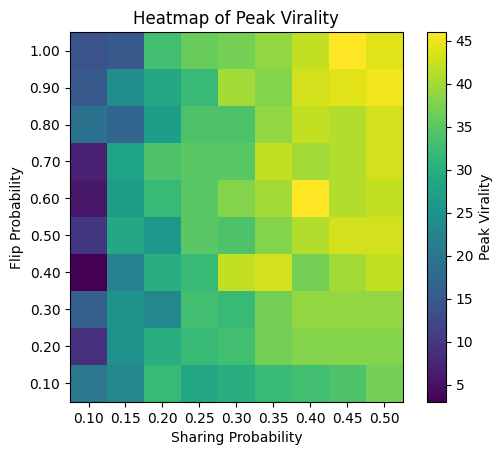

In [8]:
# Adjust run_simulation to accept sharing_prob and shared_duration, and to return peak_virality
def run_sweep(network, timesteps=50, sharing_prob=0.1, flip_prob=0.2, shared_duration=10):
    global peak_virality
    peak_virality = 0
    for t in range(timesteps):
        peak_virality = update_network(network, sharing_prob, flip_prob, shared_duration)
    return peak_virality

# Set up the parameter sweep range
sharing_probs = np.arange(0.1, 0.55, 0.05)  # Sharing probability from 0.1 to 0.5
flip_probs = np.arange(0.1, 1.1, 0.1)  # Flip probability from 0.1 to 0.5

# Initialize the results matrix
results = np.zeros((len(flip_probs), len(sharing_probs)))

# Run the parameter sweep
for i, flip_prob in enumerate(flip_probs):
    for j, sharing_prob in enumerate(sharing_probs):
        network = initialize()
        peak_virality = run_sweep(network, sharing_prob=sharing_prob, flip_prob=flip_prob)
        results[i, j] = peak_virality

print(results)

# Create a heatmap to visualize the peak virality
fig, ax = plt.subplots()

# Create the heatmap using the results matrix
cax = ax.imshow(results, cmap='viridis', origin='lower')

# Add a colorbar with a label
cbar = fig.colorbar(cax)
cbar.set_label('Peak Virality')

# Set the tick marks for the sharing probability on the x-axis
sharing_probs_labels = np.arange(0.1, 0.55, 0.05)
ax.set_xticks(np.arange(len(sharing_probs_labels)))
ax.set_xticklabels(['{:.2f}'.format(p) for p in sharing_probs_labels])

# Set the tick marks for the flip probability on the y-axis
flip_probs_labels = np.arange(0.1, 1.1, 0.1)
ax.set_yticks(np.arange(len(flip_probs_labels)))
ax.set_yticklabels(['{:.2f}'.format(f) for f in flip_probs_labels])

# Label the axes
ax.set_xlabel('Sharing Probability')
ax.set_ylabel('Flip Probability')

# Set the title of the heatmap
ax.set_title('Heatmap of Peak Virality')

# Display the plot
plt.show()